In [1]:
import sys
sys.path.insert(0, '../python')
sys.path.insert(0, '../')
import torch
import util
from model import handpose_model
import numpy as np
import cv2
import util
import math
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms

In [4]:
model = handpose_model()

model_dict = torch.load('../model/hand_pose_model.pth')

model.load_state_dict(util.transfer(model, model_dict))

test_image = '../images/hand.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order

scale_search = [0.5, 1.0, 1.5, 2.0]
# scale_search = [0.5]
boxsize = 368
stride = 8
padValue = 128
thre1 = 0.1
thre2 = 0.05
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
# paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)

    data = torch.from_numpy(im).float()
    if torch.cuda.is_available():
        data = data.cuda()
    # data = data.permute([2, 0, 1]).unsqueeze(0).float()
    with torch.no_grad():
        output = model(data).numpy()

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg += heatmap / len(multiplier)

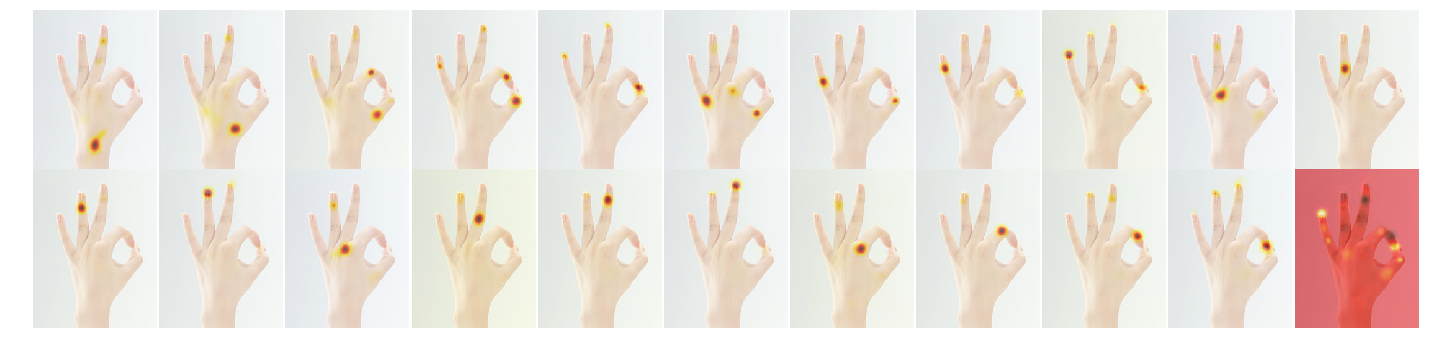

In [5]:
f, axarr = plt.subplots(2, 11)
f.set_size_inches((20, 5))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(22):
    ax = axarr[i//11, i%11]
    ax.imshow(oriImg[:, :, [2, 1, 0]])
    ax.imshow(heatmap_avg[:, :, i], alpha=.5, cmap=plt.cm.hot_r)
    ax.axis('off')